In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.core.interactiveshell import InteractiveShell
import zipfile
import os
import seaborn as sns
import pickle
import time
import sys
import gc
%matplotlib inline

In [38]:
zf = zipfile.ZipFile('competitive-data-science-predict-future-sales.zip')

In [5]:

# Read items
items = pd.read_csv(zf.open('items.csv'))

# Read sales train
train = pd.read_csv(zf.open('sales_train.csv'))


# Read item categories
item_categories = pd.read_csv(zf.open('item_categories.csv'))

# Read shops
shops = pd.read_csv(zf.open('shops.csv'))

# Read test
test = pd.read_csv(zf.open('test.csv'))

In [6]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [9]:
train['date'][0].year

2013

In [12]:
#combine all required dataets to create our training set

train = train.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [14]:
train.shape

(2935849, 10)

In [15]:
#exploiting the data leakage, 
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
lk_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]


In [24]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0],'\nPercent Data Reduction:', round(100*lk_train.shape[0]/train.shape[0],2), '%')

Data set size before leaking: 2935849
Data set size after leaking: 1224439 
Percent Data reduction: 41.71 %


In [25]:
lk_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
10,2013-01-03,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
11,2013-01-05,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
12,2013-01-07,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
13,2013-01-08,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства


In [26]:
# Select only useful features.removing text features
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [ ]:
# Group by month in this case "date_block_num" and aggregate features.


In [55]:
train_monthly_draft = train_monthly.sort_values('date').groupby(['shop_id'], as_index = False)

In [56]:
train_monthly_draft.head()

,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
112089,2013-01-01,0,42,55,2090,449.0,1.0
108984,2013-01-01,0,46,40,14390,149.0,1.0
108985,2013-01-01,0,46,40,14389,149.0,1.0
18128,2013-01-01,0,28,19,4906,1799.0,1.0
21124,2013-01-01,0,28,65,16135,249.0,1.0
...,...,...,...,...,...,...,...
2894886,2015-10-18,33,36,40,17374,149.0,1.0
2894882,2015-10-18,33,36,63,15287,1099.0,1.0
2894873,2015-10-18,33,36,40,14801,449.0,1.0
2894850,2015-10-18,33,36,40,15798,399.0,1.0


In [62]:
train_monthly_draft = train_monthly.sort_values('date').groupby(['date_block_num','shop_id'], as_index = False)

In [63]:
train_monthly_draft.head()

,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
112089,2013-01-01,0,42,55,2090,449.0,1.0
108984,2013-01-01,0,46,40,14390,149.0,1.0
108985,2013-01-01,0,46,40,14389,149.0,1.0
18128,2013-01-01,0,28,19,4906,1799.0,1.0
21124,2013-01-01,0,28,65,16135,249.0,1.0
...,...,...,...,...,...,...,...
2894886,2015-10-18,33,36,40,17374,149.0,1.0
2894882,2015-10-18,33,36,63,15287,1099.0,1.0
2894873,2015-10-18,33,36,40,14801,449.0,1.0
2894850,2015-10-18,33,36,40,15798,399.0,1.0


In [64]:
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)

In [66]:
train_monthly.head()

,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
112089,2013-01-01,0,42,55,2090,449.0,1.0
108984,2013-01-01,0,46,40,14390,149.0,1.0
108985,2013-01-01,0,46,40,14389,149.0,1.0
18128,2013-01-01,0,28,19,4906,1799.0,1.0
21124,2013-01-01,0,28,65,16135,249.0,1.0
...,...,...,...,...,...,...,...
2915929,2015-10-31,33,6,24,7136,3599.0,1.0
2933031,2015-10-31,33,25,40,12088,399.0,1.0
2930135,2015-10-31,33,24,55,7462,349.0,1.0
2893277,2015-10-31,33,38,67,19291,999.0,1.0


In [68]:
type(train_monthly)

pandas.core.groupby.generic.DataFrameGroupBy

In [75]:
print(14//12)
print(14%12)
print(14/12)

1
2
1.1666666666666667


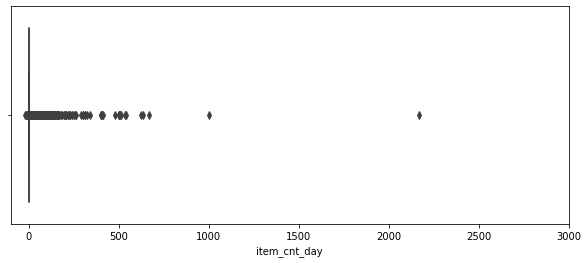

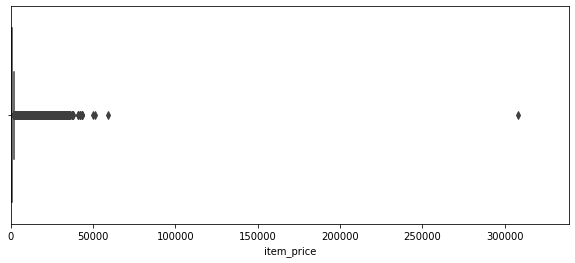

In [79]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [85]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id))))


363

In [87]:
len(list(set(test.item_id)))


5100

In [83]:
len(test)

214200

Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs.
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs.

In [89]:
len(set(test.shop_id))

42

In [90]:
test.shop_id.unique()

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int64)

In [92]:
from itertools import product

In [93]:
matrix = []
sales = train[train.date_block_num==1]
matrix.append(np.array(list(product([1], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))


In [115]:
len(matrix[0])

375728

In [107]:
print(matrix[0][8168])

[   1   47 3880]


In [116]:
len(sales.shop_id.unique())

46

In [104]:
len(set(sales.item_id.unique()))

8168

In [123]:
sales.nunique()

date                    28
date_block_num           1
shop_id                 46
item_id               8168
item_price            1962
item_cnt_day            36
item_name             8168
item_category_id        57
shop_name               46
item_category_name      57
dtype: int64

In [126]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})

In [125]:
group.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              0       32               6.0
                       33               3.0
                       35               1.0
                       43               1.0
                       51               2.0

In [131]:
data = {"Team": ["Red Sox", "Red Sox", "Red Sox", "Red Sox", "Red Sox", "Red Sox", "Yankees", "Yankees", "Yankees", "Yankees", "Yankees", "Yankees"],
		"Pos": ["Pitcher", "Pitcher", "Pitcher", "Not Pitcher", "Not Pitcher", "Not Pitcher", "Pitcher", "Pitcher", "Pitcher", "Not Pitcher", "Not Pitcher", "Not Pitcher"],
		"Age": [24, 28, 40, 22, 29, 33, 31, 26, 21, 36, 25, 31]}
df = pd.DataFrame(data)
print(df)

       Team          Pos  Age
0   Red Sox      Pitcher   24
1   Red Sox      Pitcher   28
2   Red Sox      Pitcher   40
3   Red Sox  Not Pitcher   22
4   Red Sox  Not Pitcher   29
5   Red Sox  Not Pitcher   33
6   Yankees      Pitcher   31
7   Yankees      Pitcher   26
8   Yankees      Pitcher   21
9   Yankees  Not Pitcher   36
10  Yankees  Not Pitcher   25
11  Yankees  Not Pitcher   31


In [146]:
grouped_single =df.groupby(['Team']).agg({'Age': ['mean', 'max', 'min']})

In [147]:
grouped_single.columns = ['age_mean', 'age_max', 'age_min']

In [151]:
grouped_single.reset_index()

,Team,age_mean,age_max,age_min
0,Red Sox,29.333333,40,22
1,Yankees,28.333333,36,21


In [ ]:
group1 = train.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day']

In [155]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


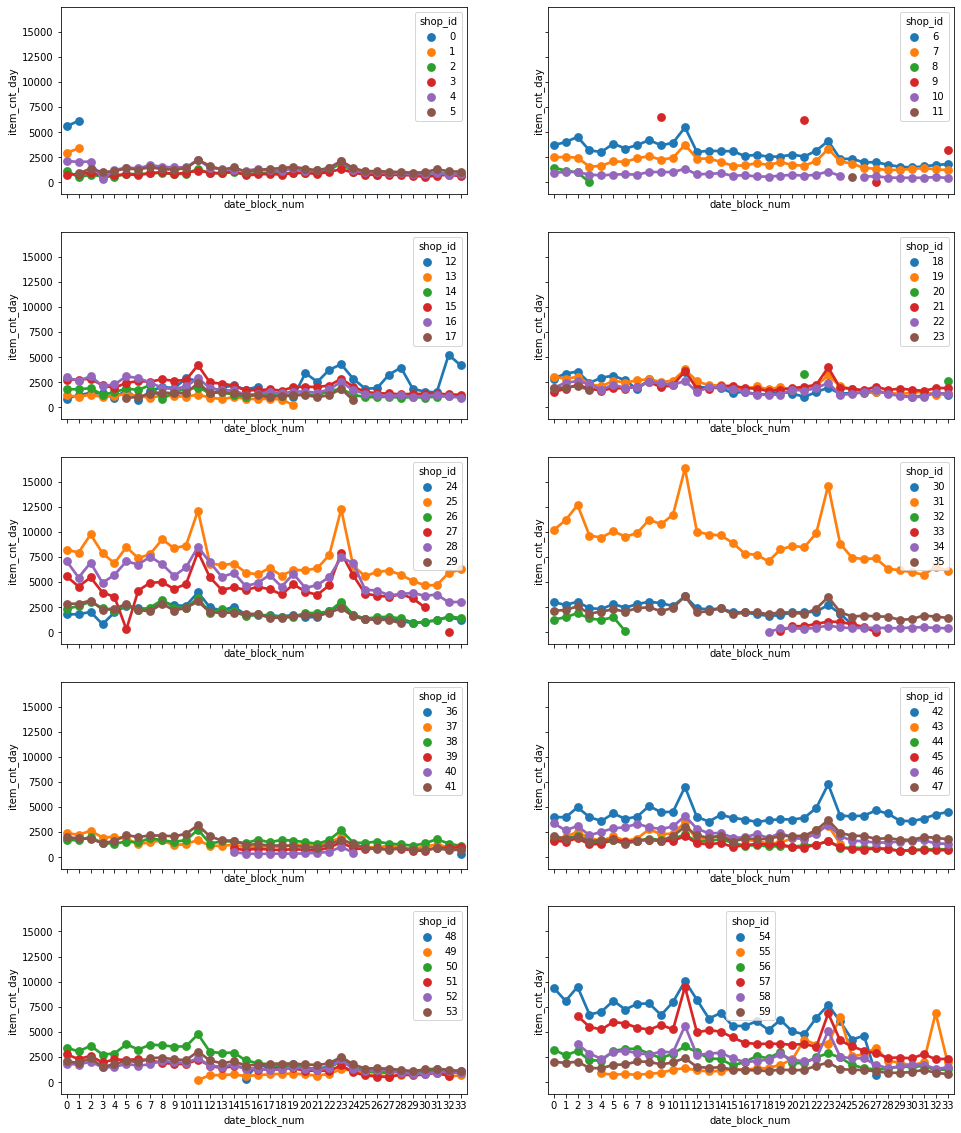

In [158]:
from math import ceil
grouped = pd.DataFrame(sales_train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

In [163]:
# add categories
sales_train = sales_train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()

In [166]:
sales_train.head()

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id
0,0,2014-09-01,20,54,58.0,1.0,40
1,1,2014-04-04,15,55,4490.0,1.0,76
2,1,2014-04-02,15,55,4490.0,1.0,76
3,1,2014-07-06,18,55,4490.0,1.0,76
4,1,2014-08-04,19,55,4490.0,1.0,76


In [170]:
sales_train['date']  = pd.to_datetime(sales_train['date'])

In [171]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   item_id           int64         
 1   date              datetime64[ns]
 2   date_block_num    int64         
 3   shop_id           int64         
 4   item_price        float64       
 5   item_cnt_day      float64       
 6   item_category_id  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 156.8 MB


In [175]:
sales_train['month'] = sales_train['date'].apply(lambda x: x.month)

In [178]:
sales_train['year'] = sales_train['date'].apply(lambda x: x.year)

In [179]:
sales_train.head()

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id,month,year
0,0,2014-09-01,20,54,58.0,1.0,40,9,2014
1,1,2014-04-04,15,55,4490.0,1.0,76,4,2014
2,1,2014-04-02,15,55,4490.0,1.0,76,4,2014
3,1,2014-07-06,18,55,4490.0,1.0,76,7,2014
4,1,2014-08-04,19,55,4490.0,1.0,76,8,2014


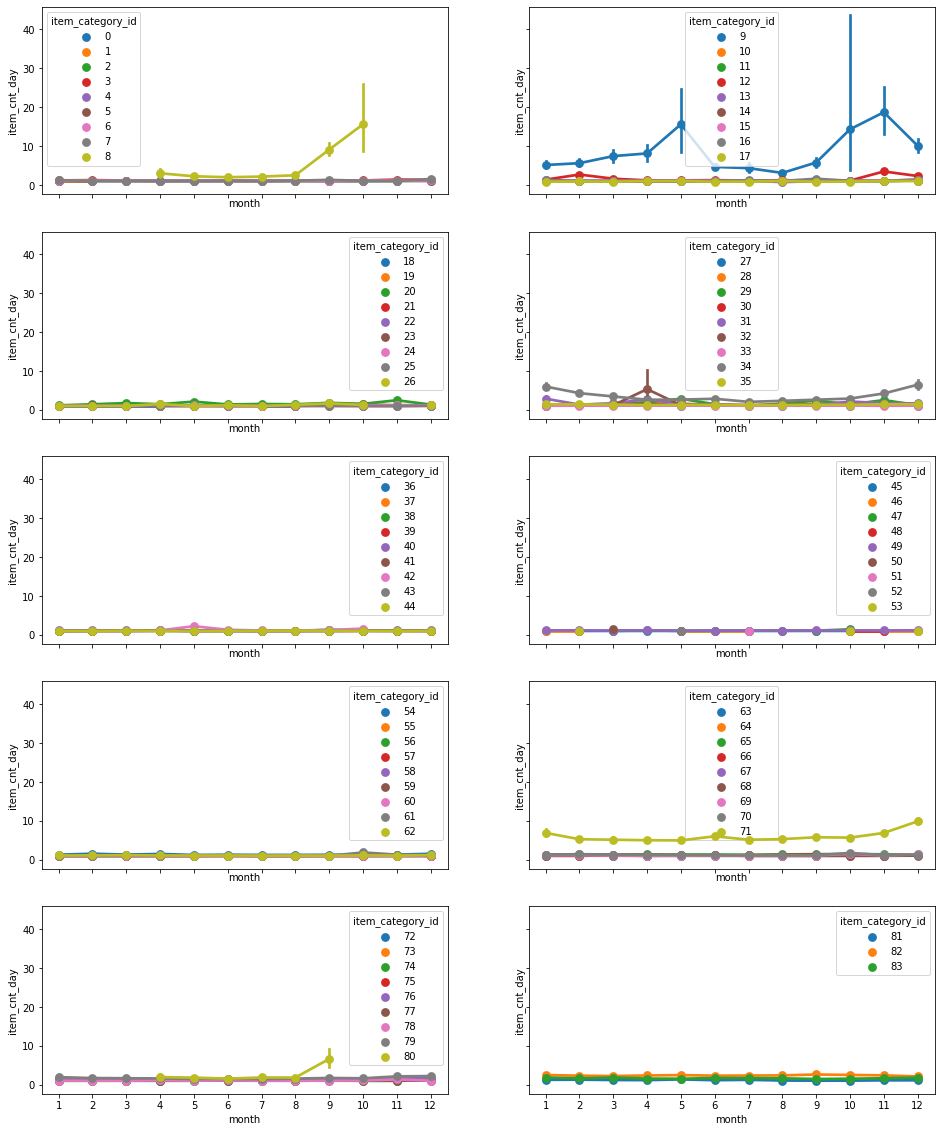

In [180]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
                      data=sales_train[np.logical_and(count*id_per_graph <= sales_train['item_category_id'], sales_train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

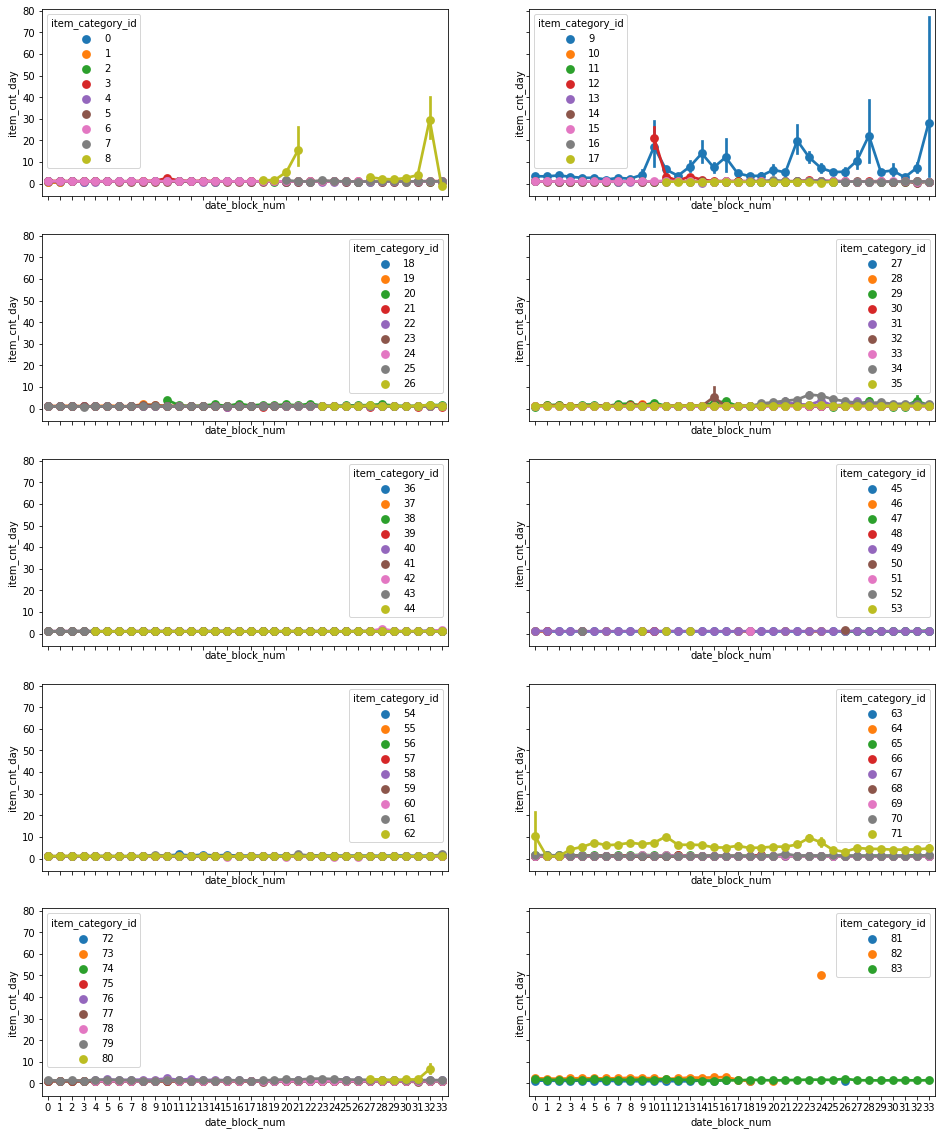

In [181]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=sales_train[np.logical_and(count*id_per_graph <= sales_train['item_category_id'], sales_train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

In [8]:
>>> import sys
>>> x = 2
>>> sys.getsizeof(x)

28

In [7]:
train = pd.read_csv(zf.open('sales_train.csv'))

In [9]:
sys.getsizeof(train)

314135995

In [184]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


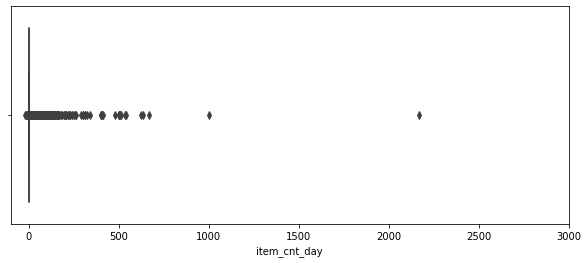

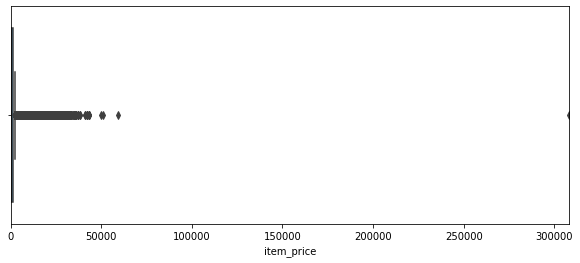

2935849
2
12
1
2935846


In [185]:
plt.figure(figsize = (10,4))
plt.xlim(-100, 3000)
sns.boxplot( x= train.item_cnt_day )
plt.figure( figsize = (10,4) )
plt.xlim(train.item_price.min(), train.item_price.max())
sns.boxplot( x = train.item_price )
plt.show()

print(train.shape[0])
print(len( train[train.item_cnt_day >999 ] ))
print( len(train[ train.item_cnt_day > 500  ]) )
print(len(train[train.item_price >100000 ]))
train = train[(train.item_price < 100000 )& (train.item_cnt_day < 1000)]
print(train.shape[0])

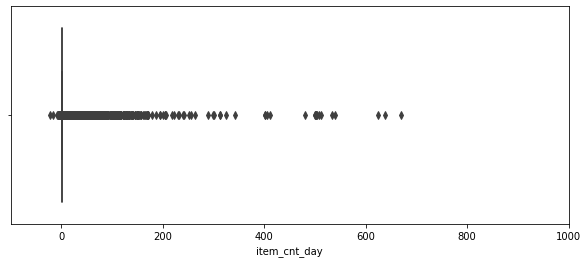

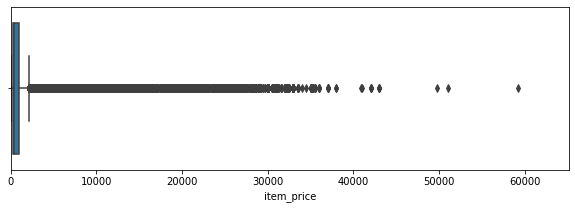

In [186]:
plt.figure(figsize = (10,4))
plt.xlim( -100, 1000 )
sns.boxplot( x= train.item_cnt_day )
plt.figure( figsize = (10,3) )
plt.xlim( train.item_price.min(), train.item_price.max()*1.1 )
sns.boxplot( x = train.item_price )
plt.show()

In [11]:
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

In [12]:
train.loc[train.shop_id == 0, "shop_id"] = 57
test.loc[test.shop_id == 0 , "shop_id"] = 57
train.loc[train.shop_id == 1, "shop_id"] = 58
test.loc[test.shop_id == 1 , "shop_id"] = 58
train.loc[train.shop_id == 11, "shop_id"] = 10
test.loc[test.shop_id == 11, "shop_id"] = 10
train.loc[train.shop_id == 40, "shop_id"] = 39
test.loc[test.shop_id == 40, "shop_id"] = 39

In [189]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [6]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [13]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

9.20340609550476

In [12]:
matrix.head(
)

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


In [14]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).clip(0,20).astype(np.float16)
time.time() - ts

4.442128896713257

In [14]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [15]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

In [16]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [16]:
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.08377552032470703

In [17]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month
11056318,34,45,18454,0.0
11056319,34,45,16188,0.0
11056320,34,45,15757,0.0
11056321,34,45,19648,0.0
11056322,34,45,969,0.0


In [18]:
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [19]:
ts = time.time()

matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


17.26340651512146

In [20]:
matrix[(matrix['item_cnt_month_lag_1']>0) & (matrix['item_cnt_month_lag_2']>0) & (matrix['item_cnt_month_lag_3']>0)].head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
1122911,3,2,482,1.0,1.0,1.0,1.0
1122912,3,2,484,3.0,2.0,4.0,2.0
1122953,3,2,785,0.0,4.0,1.0,1.0
1122955,3,2,791,2.0,2.0,1.0,2.0
1123011,3,2,1007,0.0,2.0,1.0,3.0


In [21]:
matrix['date_block_num'].min(), matrix['date_block_num'].max()

(0, 34)

In [22]:
#adding a lag feature for avg sales count by month
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


8.450418472290039

In [25]:
matrix[(matrix['item_cnt_month_lag_1']>0) & (matrix['item_cnt_month_lag_2']>0) & (matrix['item_cnt_month_lag_3']>0)].head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3
1122911,3,2,482,1.0,1.0,1.0,1.0,0.356201,2.783203,2.064453,2.644531
1122912,3,2,484,3.0,2.0,4.0,2.0,0.356201,2.869141,4.195312,3.666016
1122953,3,2,785,0.0,4.0,1.0,1.0,0.356201,1.043945,1.369141,1.400391
1122955,3,2,791,2.0,2.0,1.0,2.0,0.356201,2.238281,2.347656,2.000000
1123011,3,2,1007,0.0,2.0,1.0,3.0,0.356201,2.890625,1.543945,0.266602


In [26]:
#adding three lag features for avg sales count by month and item_id
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


21.828216314315796

In [27]:
matrix[(matrix['item_cnt_month_lag_1']>0) & (matrix['item_cnt_month_lag_2']>0) & (matrix['item_cnt_month_lag_3']>0)].head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1_x,date_item_avg_item_cnt_lag_2_x,date_item_avg_item_cnt_lag_3_x,date_item_avg_item_cnt_lag_1_y,date_item_avg_item_cnt_lag_2_y,date_item_avg_item_cnt_lag_3_y
1122911,3,2,482,1.0,1.0,1.0,1.0,0.356201,2.783203,2.064453,2.644531,2.783203,2.064453,2.644531
1122912,3,2,484,3.0,2.0,4.0,2.0,0.356201,2.869141,4.195312,3.666016,2.869141,4.195312,3.666016
1122953,3,2,785,0.0,4.0,1.0,1.0,0.356201,1.043945,1.369141,1.400391,1.043945,1.369141,1.400391
1122955,3,2,791,2.0,2.0,1.0,2.0,0.356201,2.238281,2.347656,2.000000,2.238281,2.347656,2.000000
1123011,3,2,1007,0.0,2.0,1.0,3.0,0.356201,2.890625,1.543945,0.266602,2.890625,1.543945,0.266602


In [28]:
#adding three lag features for avg sales count by month and shop_id
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

C:\Users\jhanw\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


date_shop_avg_item_cnt


22.25506901741028

In [29]:
matrix[(matrix['item_cnt_month_lag_1']>0) & (matrix['item_cnt_month_lag_2']>0) & (matrix['item_cnt_month_lag_3']>0)].head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1_x,date_item_avg_item_cnt_lag_2_x,date_item_avg_item_cnt_lag_3_x,date_item_avg_item_cnt_lag_1_y,date_item_avg_item_cnt_lag_2_y,date_item_avg_item_cnt_lag_3_y,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3
1122911,3,2,482,1.0,1.0,1.0,1.0,0.356201,2.783203,2.064453,2.644531,2.783203,2.064453,2.644531,0.09082,0.059875,0.141846
1122912,3,2,484,3.0,2.0,4.0,2.0,0.356201,2.869141,4.195312,3.666016,2.869141,4.195312,3.666016,0.09082,0.059875,0.141846
1122953,3,2,785,0.0,4.0,1.0,1.0,0.356201,1.043945,1.369141,1.400391,1.043945,1.369141,1.400391,0.09082,0.059875,0.141846
1122955,3,2,791,2.0,2.0,1.0,2.0,0.356201,2.238281,2.347656,2.000000,2.238281,2.347656,2.000000,0.09082,0.059875,0.141846
1123011,3,2,1007,0.0,2.0,1.0,3.0,0.356201,2.890625,1.543945,0.266602,2.890625,1.543945,0.266602,0.09082,0.059875,0.141846


In [30]:
#adding three lag features for avg sales count by (month, shop_id and item_id)
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

C:\Users\jhanw\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


date_shop_item_avg_item_cnt


31.976120948791504

In [31]:
matrix[(matrix['item_cnt_month_lag_1']>0) & (matrix['item_cnt_month_lag_2']>0) & (matrix['item_cnt_month_lag_3']>0)].head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1_x,date_item_avg_item_cnt_lag_2_x,date_item_avg_item_cnt_lag_3_x,date_item_avg_item_cnt_lag_1_y,date_item_avg_item_cnt_lag_2_y,date_item_avg_item_cnt_lag_3_y,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3
1122911,3,2,482,1.0,1.0,1.0,1.0,0.356201,2.783203,2.064453,2.644531,2.783203,2.064453,2.644531,0.09082,0.059875,0.141846,1.0,1.0,1.0
1122912,3,2,484,3.0,2.0,4.0,2.0,0.356201,2.869141,4.195312,3.666016,2.869141,4.195312,3.666016,0.09082,0.059875,0.141846,2.0,4.0,2.0
1122953,3,2,785,0.0,4.0,1.0,1.0,0.356201,1.043945,1.369141,1.400391,1.043945,1.369141,1.400391,0.09082,0.059875,0.141846,4.0,1.0,1.0
1122955,3,2,791,2.0,2.0,1.0,2.0,0.356201,2.238281,2.347656,2.000000,2.238281,2.347656,2.000000,0.09082,0.059875,0.141846,2.0,1.0,2.0
1123011,3,2,1007,0.0,2.0,1.0,3.0,0.356201,2.890625,1.543945,0.266602,2.890625,1.543945,0.266602,0.09082,0.059875,0.141846,2.0,1.0,3.0


In [32]:
ts = time.time()
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)
time.time() - ts

2.2759182453155518

In [33]:
matrix[(matrix['item_cnt_month_lag_1']>0) & (matrix['item_cnt_month_lag_2']>0) & (matrix['item_cnt_month_lag_3']>0)].head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1_x,date_item_avg_item_cnt_lag_2_x,...,date_item_avg_item_cnt_lag_1_y,date_item_avg_item_cnt_lag_2_y,date_item_avg_item_cnt_lag_3_y,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,item_avg_item_price
1122911,3,2,482,1.0,1.0,1.0,1.0,0.356201,2.783203,2.064453,...,2.783203,2.064453,2.644531,0.09082,0.059875,0.141846,1.0,1.0,1.0,3230.00
1122912,3,2,484,3.0,2.0,4.0,2.0,0.356201,2.869141,4.195312,...,2.869141,4.195312,3.666016,0.09082,0.059875,0.141846,2.0,4.0,2.0,293.50
1122953,3,2,785,0.0,4.0,1.0,1.0,0.356201,1.043945,1.369141,...,1.043945,1.369141,1.400391,0.09082,0.059875,0.141846,4.0,1.0,1.0,343.75
1122955,3,2,791,2.0,2.0,1.0,2.0,0.356201,2.238281,2.347656,...,2.238281,2.347656,2.000000,0.09082,0.059875,0.141846,2.0,1.0,2.0,593.50
1123011,3,2,1007,0.0,2.0,1.0,3.0,0.356201,2.890625,1.543945,...,2.890625,1.543945,0.266602,0.09082,0.059875,0.141846,2.0,1.0,3.0,581.50


In [34]:
ts = time.time()
group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
time.time()-ts

2.6409430503845215

In [63]:
matrix[(matrix['item_cnt_month_lag_1']>0) & (matrix['item_cnt_month_lag_2']>0) & (matrix['item_cnt_month_lag_3']>0)].head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,item_avg_item_price,date_item_avg_item_price
1122911,3,2,482,1.0,1.0,1.0,1.0,0.355469,2.783203,2.064453,2.623047,0.090454,0.059875,0.141235,1.0,1.0,1.0,3230.00,3276.00
1122912,3,2,484,3.0,2.0,4.0,2.0,0.355469,2.826172,4.175781,3.623047,0.090454,0.059875,0.141235,2.0,4.0,2.0,293.50,296.00
1122953,3,2,785,0.0,4.0,1.0,1.0,0.355469,1.043945,1.369141,1.377930,0.090454,0.059875,0.141235,4.0,1.0,1.0,343.75,340.25
1122955,3,2,791,2.0,2.0,1.0,2.0,0.355469,2.216797,2.326172,2.000000,0.090454,0.059875,0.141235,2.0,1.0,2.0,593.50,588.00
1123011,3,2,1007,0.0,2.0,1.0,3.0,0.355469,2.890625,1.543945,0.266602,0.090454,0.059875,0.141235,2.0,1.0,3.0,581.50,445.00


In [35]:
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

date_item_avg_item_price


In [65]:
matrix[(matrix['item_cnt_month_lag_1']>0) & (matrix['item_cnt_month_lag_2']>0) & (matrix['item_cnt_month_lag_3']>0)].head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,...,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3
1122911,3,2,482,1.0,1.0,1.0,1.0,0.355469,2.783203,2.064453,...,1.0,1.0,3230.00,3276.00,3234.00,3192.00,3188.00,0.001239,-0.011765,-0.013000
1122912,3,2,484,3.0,2.0,4.0,2.0,0.355469,2.826172,4.175781,...,4.0,2.0,293.50,296.00,298.50,291.75,286.50,0.017029,-0.005962,-0.023849
1122953,3,2,785,0.0,4.0,1.0,1.0,0.355469,1.043945,1.369141,...,1.0,1.0,343.75,340.25,340.25,340.75,347.25,-0.010185,-0.008728,0.010185
1122955,3,2,791,2.0,2.0,1.0,2.0,0.355469,2.216797,2.326172,...,1.0,2.0,593.50,588.00,600.00,596.00,595.50,0.010948,0.004211,0.003370
1123011,3,2,1007,0.0,2.0,1.0,3.0,0.355469,2.890625,1.543945,...,1.0,3.0,581.50,445.00,440.75,439.75,421.50,-0.242065,-0.243774,-0.275146


In [36]:
def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

In [37]:
features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )

In [38]:
features_to_drop

['item_avg_item_price',
 'date_item_avg_item_price',
 'date_item_avg_item_price_lag_1',
 'delta_price_lag_1',
 'date_item_avg_item_price_lag_2',
 'delta_price_lag_2',
 'date_item_avg_item_price_lag_3',
 'delta_price_lag_3']

In [39]:
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [40]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,0.0,0.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [41]:
ts = time.time()
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)
time.time() - ts

2.8394126892089844

In [43]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1_x,date_item_avg_item_cnt_lag_2_x,...,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag,date_shop_revenue
0,0,2,19,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,28.000,28.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1091137.0
1,0,2,27,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1461.000,2324.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1091137.0
2,0,2,28,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,310.000,549.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1091137.0
3,0,2,29,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1759.000,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1091137.0
4,0,2,32,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,249.625,338.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1091137.0


In [44]:
matrix.drop(['date_shop_revenue'], axis= 1, inplace =True)

In [45]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1_x,date_item_avg_item_cnt_lag_2_x,...,date_shop_item_avg_item_cnt_lag_3,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag
0,0,2,19,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,28.000,28.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,2,27,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1461.000,2324.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0,2,28,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,310.000,549.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0,2,29,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1759.000,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0,2,32,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,249.625,338.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [46]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)


In [1]:
matrix.tail()

NameError: name 'matrix' is not defined

NameError: name 'matrix' is not defined

NameError: name 'matrix' is not defined

In [84]:
filename = 'matrix_data'
outfile = open(filename, 'wb')
pickle.dump(matrix, outfile)
outfile.close()

In [2]:
import os
import gc
import pickle
import time
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [17]:
ts =time.time()
filename = 'matrix_data'
infile = open(filename,'rb')
matrix = pickle.load(infile)
infile.close()

time.time() - ts

0.6722073554992676

In [18]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1_x,date_item_avg_item_cnt_lag_2_x,...,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag,month,days
0,0,2,19,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,28.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,31
1,0,2,27,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2324.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,31
2,0,2,28,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,549.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,31
3,0,2,29,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,31
4,0,2,32,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,338.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,31


In [1]:
pwd

'C:\\drive\\ml\\coursera\\win kaggle competion course\\competitive-data-science-final-project'

In [19]:
matrix_subset = matrix.sample(frac = 0.3, replace = False, random_state = 1)

In [20]:
#X_test needs to be created using complete matrix data as it will be used for predicting y_test 
#and y_test will be used for submission
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
del matrix

In [24]:
gc.collect()

20

In [25]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('matrix_subset', 218915226),
 ('X_train', 203619288),
 ('Y_train', 31815534),
 ('X_test', 13708824),
 ('X_valid', 4557528),
 ('Y_valid', 712134),
 ('rcParams', 9336),
 ('XGBRegressor', 1056),
 ('infile', 176),
 ('filename', 84),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('ts', 24)]

(214200, 31)

In [26]:
X_train = matrix_subset[matrix_subset.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = matrix_subset[matrix_subset.date_block_num < 33]['item_cnt_month']
X_valid = matrix_subset[matrix_subset.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix_subset[matrix_subset.date_block_num == 33]['item_cnt_month']


In [27]:
X_test.shape

(214200, 30)

In [31]:
zf = zipfile.ZipFile('competitive-data-science-predict-future-sales.zip')
test = pd.read_csv(zf.open('test.csv')).set_index('ID')
test.shape, X_test.shape

((214200, 2), (214200, 30))

In [38]:
test.shape, X_test.shape

((214200, 2), (214200, 30))

In [39]:
ts = time.time()

model = XGBRegressor(
    max_depth=5,
    n_estimators=250,
    min_child_weight=0.5, 
    colsample_bytree=0.7, 
    subsample=0.7, 
    eta=0.01,
    #tree_method='gpu_hist',
    reg_lambda =5,
    n_jobs =-1,
    seed=42)

time.time() - ts

0.0009975433349609375

In [33]:
ts = time.time()
model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 15)

time.time() - ts

[0]	validation_0-rmse:1.24039	validation_1-rmse:1.12559
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 15 rounds.
[1]	validation_0-rmse:1.23664	validation_1-rmse:1.12292
[2]	validation_0-rmse:1.23268	validation_1-rmse:1.11967
[3]	validation_0-rmse:1.22711	validation_1-rmse:1.11645
[4]	validation_0-rmse:1.22246	validation_1-rmse:1.11329
[5]	validation_0-rmse:1.21815	validation_1-rmse:1.11016
[6]	validation_0-rmse:1.21424	validation_1-rmse:1.10705
[7]	validation_0-rmse:1.20962	validation_1-rmse:1.10407
[8]	validation_0-rmse:1.20592	validation_1-rmse:1.10112
[9]	validation_0-rmse:1.20191	validation_1-rmse:1.09814
[10]	validation_0-rmse:1.19816	validation_1-rmse:1.09529
[11]	validation_0-rmse:1.19312	validation_1-rmse:1.09251
[12]	validation_0-rmse:1.18971	validation_1-rmse:1.08979
[13]	validation_0-rmse:1.18612	validation_1-rmse:1.08709
[14]	validation_0-rmse:1.18210	validation_1-rmse:1.08

[141]	validation_0-rmse:0.98528	validation_1-rmse:0.95941
[142]	validation_0-rmse:0.98479	validation_1-rmse:0.95922
[143]	validation_0-rmse:0.98426	validation_1-rmse:0.95903
[144]	validation_0-rmse:0.98380	validation_1-rmse:0.95882
[145]	validation_0-rmse:0.98338	validation_1-rmse:0.95861
[146]	validation_0-rmse:0.98295	validation_1-rmse:0.95840
[147]	validation_0-rmse:0.98248	validation_1-rmse:0.95818
[148]	validation_0-rmse:0.98203	validation_1-rmse:0.95798
[149]	validation_0-rmse:0.98163	validation_1-rmse:0.95781
[150]	validation_0-rmse:0.98119	validation_1-rmse:0.95756
[151]	validation_0-rmse:0.98085	validation_1-rmse:0.95738
[152]	validation_0-rmse:0.98046	validation_1-rmse:0.95722
[153]	validation_0-rmse:0.98000	validation_1-rmse:0.95701
[154]	validation_0-rmse:0.97959	validation_1-rmse:0.95679
[155]	validation_0-rmse:0.97908	validation_1-rmse:0.95664
[156]	validation_0-rmse:0.97871	validation_1-rmse:0.95648
[157]	validation_0-rmse:0.97835	validation_1-rmse:0.95633
[158]	validati

1275.251166343689

In [34]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, int(sys.getsizeof(globals().get(x))/10**6)) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('matrix_subset', 218),
 ('X_train', 203),
 ('Y_train', 31),
 ('X_test', 13),
 ('test', 5),
 ('X_valid', 4),
 ('InteractiveShell', 0),
 ('XGBRegressor', 0),
 ('Y_valid', 0),
 ('filename', 0),
 ('infile', 0),
 ('model', 0),
 ('np', 0),
 ('pd', 0),
 ('plt', 0),
 ('rcParams', 0),
 ('sns', 0),
 ('ts', 0),
 ('zf', 0)]

In [35]:
#pickle model

pickle.dump(model, open('XGB_model_8.pickle', 'wb'))

((214200, 2), (214200, 30))

In [36]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_8.csv', index=False)



In [37]:
# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [ ]:
#public leaderboard score
1.02 - with very less tree and depth and early stop =5
3 - very high depth 
2.1 - manual dubtract 2 from 2nd result
3.9 -after para tuning moderate depth
1.16 - more tuning , max_depth=3


In [ ]:
matrix = picke.load(open('matrix', 'rb'))